In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import style
import matplotlib
import matplotlib.gridspec as gridspec
import Sampler

This plot is going to demonstrate the period-stratification of the solution types, and secondary eccentricity depdenence.

This will be achieved by plotting $T\!-\!\lambda$, or perhaps $T\!-\!q$ coloured by the dominant solution type at each cell. Perhaps, then, there will be multiple panels for different eccentricities

In [2]:
def scale_resolution(arr, scale=2, axis=0):
    # Create a new shape with double the size along the specified axis
    new_shape = list(arr.shape)
    new_shape[axis] *= scale

    # Expand the array along a new axis after the target one
    expanded = np.expand_dims(arr, axis + 1)  # shape becomes (..., 1, ...)
    
    # Repeat the values along the new axis (splitting them evenly)
    repeated = np.repeat(expanded, scale, axis=axis + 1) / scale

    # Reshape back by merging the expanded axis with the original one
    transposed = np.reshape(repeated, new_shape)

    return transposed

# Samples

In [3]:
e0 = pickle.load(open("./plot_data/2026-01-14-plot_cube.pkl", "rb"))
e04 = pickle.load(open("./plot_data/2026-01-16-plot_cube_04.pkl", "rb"))
e08 = pickle.load(open("./plot_data/2026-01-16-plot_cube_08.pkl", "rb"))

# THE PLOT

In [4]:
# IMPORT CUBE
SCALE = 100

# MAP TO q (optional)
def convert_to_q_space(mass, parallax, target_slice, lambdas, resolution=50):
    qs = np.array([Sampler.q_from_l(l, mass, parallax) for l in lambdas])
    
    q_grid = np.linspace(qs[0],qs[-1],resolution)
    new_grid = np.zeros((target_slice.shape[0], resolution, target_slice.shape[2]))

    for i in range(len(lambdas)):
        if qs[i] >= 0 and qs[i] <= 1:
            target_index = np.argmin(abs(qs[i] - q_grid))
            new_grid[:,target_index,:] += target_slice[:,i,:]
    
    return new_grid/np.sum(new_grid)


def generate_q_cube(sc_cube):
    plx = list(sc_cube["cube"].keys())[0]
    lambda_limits = np.array([sc_cube["meta"]["lambdas"][0][0], sc_cube["meta"]["lambdas"][0][-1]])
    scale_lambdas = np.linspace(*lambda_limits**(1/4), SCALE*len(sc_cube["meta"]["lambdas"][0]))**(4)
    scale_slice = scale_resolution(sc_cube["data"][plx][:,:,:], scale=SCALE, axis=1)

    sc_cube_q = convert_to_q_space(0.4, 10, scale_slice, scale_lambdas, resolution=5*len(sc_cube["meta"]["lambdas"][0]))
    
    return sc_cube_q

e0_cube = generate_q_cube(e0)
e04_cube = generate_q_cube(e04)
e08_cube = generate_q_cube(e08)
highes = [e04_cube, e08_cube]
evals = [0.4, 0.8]

xrange = (0.01, 1)
yrange = (np.log10(e0["meta"]["periods"][-1]), np.log10(e0["meta"]["periods"][0]))

In [5]:
sc_cube = e0
qs = np.linspace(*xrange,5*len(sc_cube["meta"]["lambdas"][0]))
ps = np.log10(e0["meta"]["periods"])

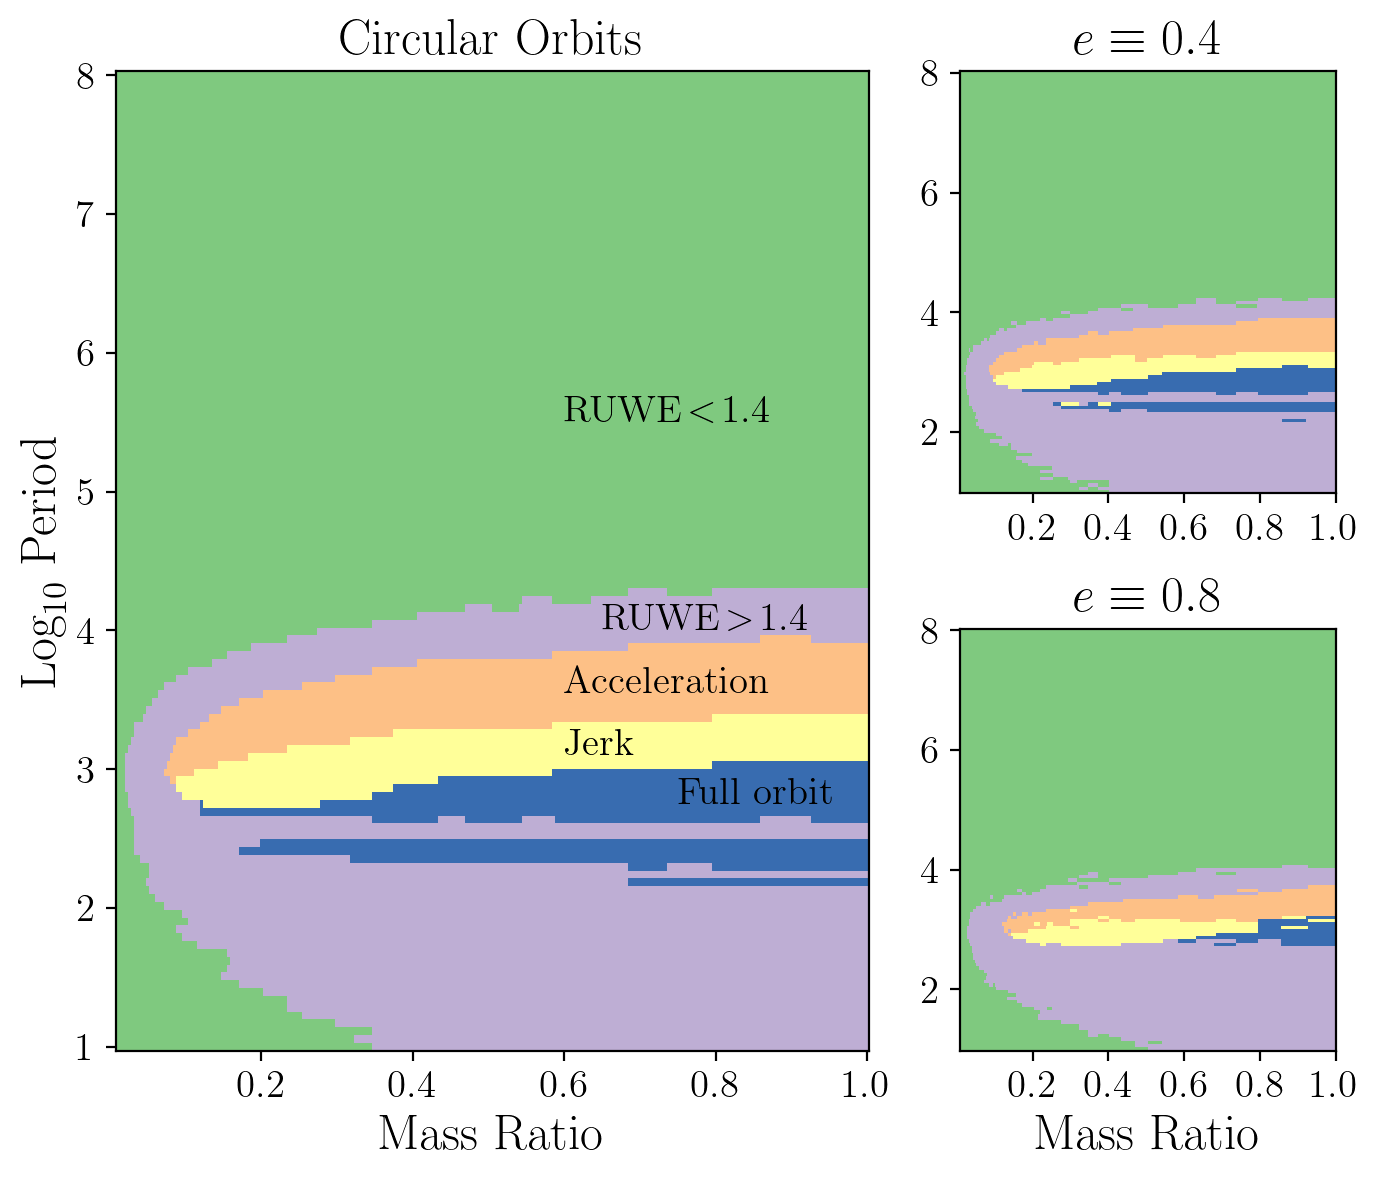

In [ ]:
# Create figure
fig = plt.figure(figsize=(7, 6), dpi=200)  # Adjust size as needed

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1])

new_colors = plt.get_cmap('Accent')(np.linspace(0, 1, 8))[:5]
CMAP = matplotlib.colors.ListedColormap(new_colors)
# Large box on the left (spans all 3 rows in column 0)
ax_big = fig.add_subplot(gs[:, 0])
#ax_big.imshow(np.argmax(e0_cube, axis=2), extent=[*xrange, *yrange], aspect="auto", cmap=CMAP);
ax_big.pcolormesh(qs, ps, np.argmax(e0_cube, axis=2), cmap=CMAP)
#ax_big.invert_yaxis()
ax_big.set_xlabel("Mass Ratio");
ax_big.set_ylabel(r"$\text{Log}_{10}$ Period");
ax_big.text(0.75,2.75, r"Full orbit", fontsize=14)
ax_big.text(0.6,3.1, r"Jerk", fontsize=14)
ax_big.text(0.6,3.55, r"Acceleration", fontsize=14)
ax_big.text(0.65,4.0, r"$\text{RUWE}\!>\!1.4$", fontsize=14)
ax_big.text(0.6,5.5, r"$\text{RUWE}\!<\!1.4$", fontsize=14)
ax_big.set_title("Circular Orbits");

# Three smaller boxes on the right (each in column 1)
ax_small1 = fig.add_subplot(gs[0, 1], sharex=ax_big)
ax_small2 = fig.add_subplot(gs[1, 1], sharex=ax_big)
ax_small2.set_xlabel("Mass Ratio")

for i, ax in enumerate([ax_small1,ax_small2]):
    #ax.imshow(np.argmax(highes[i], axis=2), extent=[*xrange, *yrange], aspect="auto", cmap=CMAP);
    ax.pcolormesh(qs, ps, np.argmax(highes[i], axis=2), cmap=CMAP)
    #ax.invert_yaxis()
    ax.set_title(r"$e\equiv{}$".format(evals[i]))

plt.tight_layout()
plt.savefig("./plots/cube_plot.jpg", dpi=800);

In [7]:
sc_cube_normed = e0_cube / e0_cube.sum(axis=2, keepdims=True)
sc_cube_es_normed = [sc_cube_q_i / sc_cube_q_i.sum(axis=2, keepdims=True) for sc_cube_q_i in highes]

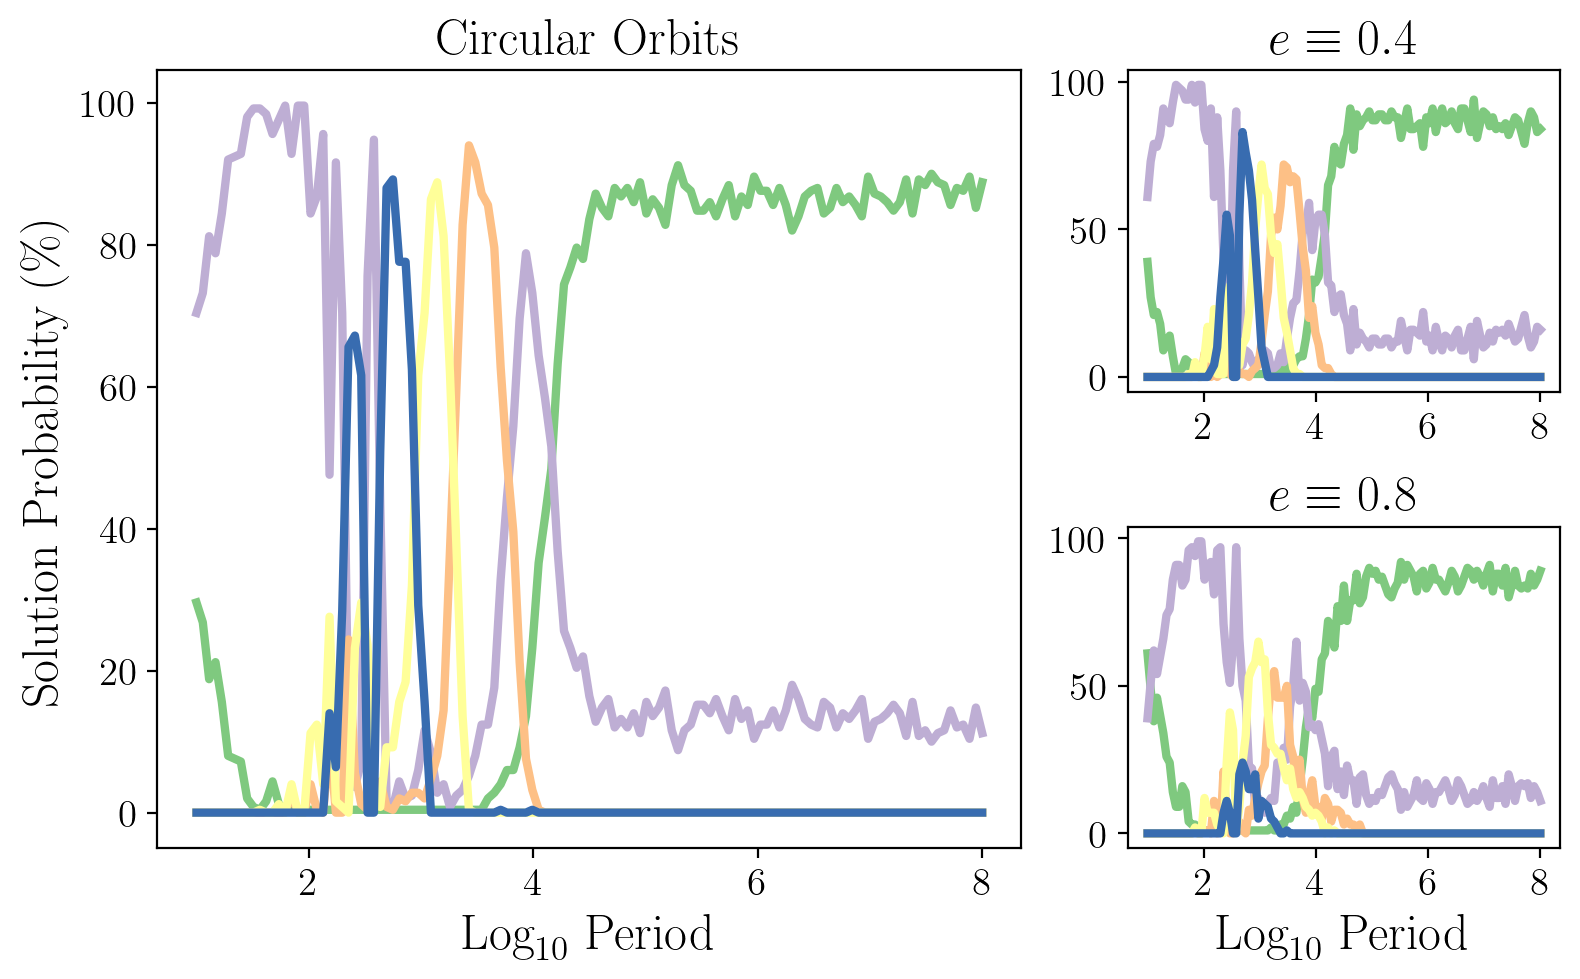

In [9]:
# Create figure
fig = plt.figure(figsize=(8, 5), dpi=200)  # Adjust size as needed

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1])

new_colors = plt.get_cmap('Accent')(np.linspace(0, 1, 8))[:5]
# Large box on the left (spans all 3 rows in column 0)
ax_big = fig.add_subplot(gs[:, 0])
k = np.argmin(abs(qs-0.5))
for i in range(5):
    ax_big.plot(np.linspace(1,8,125), sc_cube_normed[:,k,i]*100, color=new_colors[i], linewidth=3)
ax_big.set_xlabel(r"$\text{Log}_{10}$ Period");
ax_big.set_ylabel(r"Solution Probability (\%)");
ax_big.set_title("Circular Orbits");

# Three smaller boxes on the right (each in column 1)
ax_small1 = fig.add_subplot(gs[0, 1], sharex=ax_big)
ax_small2 = fig.add_subplot(gs[1, 1], sharex=ax_big)
ax_small2.set_xlabel(r"$\text{Log}_{10}$ Period");
ax_small1.set_title(r"$e\equiv{}$".format(evals[0]))
ax_small2.set_title(r"$e\equiv{}$".format(evals[1]))
for i in range(5):
    ax_small1.plot(np.linspace(1,8,125), sc_cube_es_normed[0][:,k,i]*100, color=new_colors[i], linewidth=3)
for i in range(5):
    ax_small2.plot(np.linspace(1,8,125), sc_cube_es_normed[1][:,k,i]*100, color=new_colors[i], linewidth=3)

plt.tight_layout()
plt.savefig("./plots/cube_plot_1d.jpg", dpi=800);